In [16]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
# generating the path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), "earth-analytics", "data", "camp-fire"
)

# create the project directory
os.makedirs(project_dir, exist_ok=True)

In [18]:
camp_gdf = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/Historic_Geomac_Perimeters_2018/FeatureServer/0/query?where=latest"
    "%20%3D%20'Y'%20AND%20incidentname%20%3D%20'KERLIN'&outFields=*&out"
    "SR=4326&f=json"
)

###Location of the 2018 Kerlin Fire
The 2018 fire season in California was extreme. One of those fires, was
the Kerlin Fire that started on September 4th in Trinity county near 
Hyampom (see marker on map). The fire engulfed approximately 2,000
acres of forest (see polygon on map).

In [19]:
# Butte Co CA Location

paradise_lat = 40.6173635
paradise_lon = -123.4525362 

# Create a Folium map object
m = folium.Map(location = [paradise_lat, paradise_lon], 
               scrollWheelZoom = False, tiles='Stamen Watercolor')

# Convert the GeoDataFrame to GeoJSON format
camp_geojson_data = camp_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
camp_style = {
    "fillColor": "red", "color": "black", "weight": 2, 
    "dashArray": "5, 5",
}

folium.GeoJson(camp_geojson_data, style_function=lambda 
               feature: camp_style).add_to(m)

# Add marker for paradize CA
folium.Marker(location = [paradise_lat, paradise_lon]).add_to(m)

# Display the map
m

In [20]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=project_dir,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2017, 2022],
    polygon=camp_gdf
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

In [21]:
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))


In [ ]:
doy_start = -19
doy_end = -13
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    print(ndvi_path)
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

In [23]:
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])


###The Kerlin fire resulted in extremely altered vegetation in 2019
Here is a map of the difference in NDVI the year before the fire, and 
the year after. We can see that within the fire boundary much of the 
NDVI values are negative indicating a shift in productivity, likely 
correlated with burned vegetation. We may expect recovery within a few 
years--or longer.

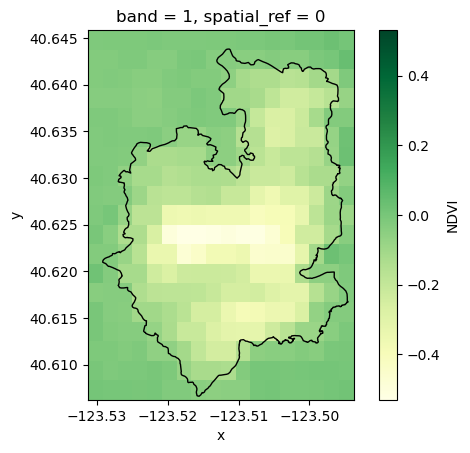

In [24]:
import matplotlib.pyplot as plt

dndvi_da = ((ndvi_ds
 .sel(date='2019')
 .mean('date')
 .NDVI)
- (ndvi_ds
 .sel(date='2017')
 .mean('date')
 .NDVI))

dndvi_da.plot(cmap=plt.colormaps['YlGn'])
camp_gdf.plot(facecolor = 'none', ax=plt.gca())

plt.show()

In [25]:
# get area outside of boundary
out_gdf = gpd.GeoDataFrame(geometry=camp_gdf.envelope).overlay(
    camp_gdf, how="difference"
)

In [26]:
ndvi_fire_ds = ndvi_ds.rio.clip(camp_gdf.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [27]:
ndvi_fire_df = (
    ndvi_fire_ds
    .groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])

ndvi_out_df = (
    ndvi_out_ds
    .groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])

###Vegetation has not recovered after the Kerlin Fire within 3 years.
NDVI dropped by 0.17 inside the boundary the year after the Kerlin Fire.
NDVI does not allow us to distinguish between forest growth and other
vegetation, so the recovery we see may not be forest recovery, but is 
likely composed of understory species. 

<Axes: title={'center': 'Difference in NDVI between inside and outside the Kerlin Fire boundary'}, xlabel='Year'>

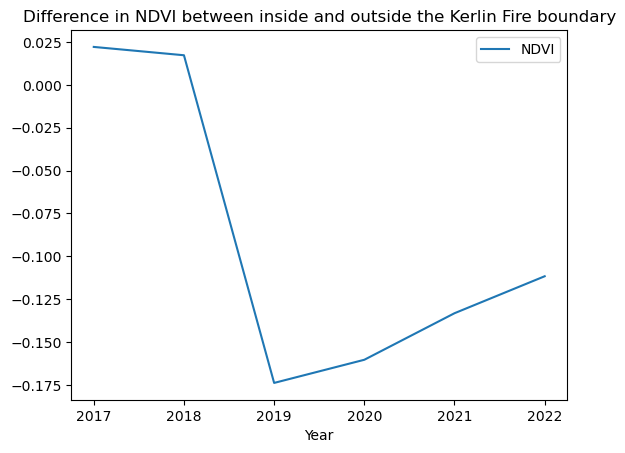

In [32]:
(ndvi_fire_df-ndvi_out_df).plot(xlabel = 'Year', 
        title = 'Difference in NDVI between inside and outside the '
        'Kerlin Fire boundary')

###Data Citation

ORNL DAAC 2018. MODIS and VIIRS Land Products Global Subsetting and 
Visualization Tool. ORNL DAAC, Oak Ridge, Tennessee, USA. Accessed 
September 09, 2023. Subset obtained for MOD13Q1 product at 40.6173635 N
-123.4525362 W, time period: 2018, and subset size: 620.5 km x 620.5 km. 
https://doi.org/10.3334/ORNLDAAC/1379

In [31]:
%%capture
%%bash
jupyter nbconvert fire_veg.ipynb --to html --no-input